In [4]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from keras import layers

from keras.applications import VGG16
from keras.applications import MobileNet 
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import Xception

#from datasets import load_dataset

import pathlib

# List all available GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        # Enable memory growth for each GPU
        # This prevents TensorFlow from allocating all GPU memory at once
        # Instead, it allocates memory dynamically as needed
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# # Load the dataset from Hugging Face
# dataset = load_dataset("Rekzi/cat-breeds", cache_dir="cat_breeds")
# print("Dataset splits:", dataset.keys())

In [5]:
data_dir = "./cat_breeds_4"
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('cat_breeds_4')

In [6]:
img_width = 224
img_height = 224
batch_size = 20

In [7]:
split = 0.2
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,                       # Main directory containing all class folders
    validation_split=split,           # 20% for validation
    subset="training",              # Specify we want the training subset
    seed=123,                       # For reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check the class names that were found
class_names = train_ds.class_names
print(class_names)

Found 3999 files belonging to 4 classes.
Using 3200 files for training.


I0000 00:00:1743557223.774449   23575 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2142 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 3999 files belonging to 4 classes.
Using 799 files for validation.
['American Shorthair', 'Persian', 'Russian Blue', 'Tiger']


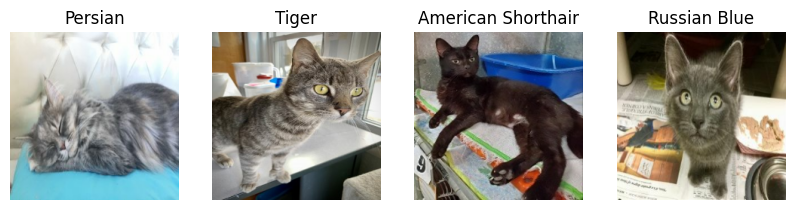

In [10]:
plt.figure(figsize=(10, 10))
unique = []
for images, labels in train_ds.take(1):
  for i in range(len(images)):
    if(class_names[labels[i]] in unique):
      continue
    ax = plt.subplot(1, 4, len(unique) + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    unique.append(class_names[labels[i]])

In [8]:
# Collect labels from training dataset
train_labels = []
for _, y in train_ds:
    train_labels.extend(y.numpy())

# Collect labels from validation dataset
val_labels = []
for _, y in val_ds:
    val_labels.extend(y.numpy())

# Combine and analyze labels
all_train_labels = np.array(train_labels)
all_val_labels = np.array(val_labels)

2025-04-02 06:58:26.621273: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


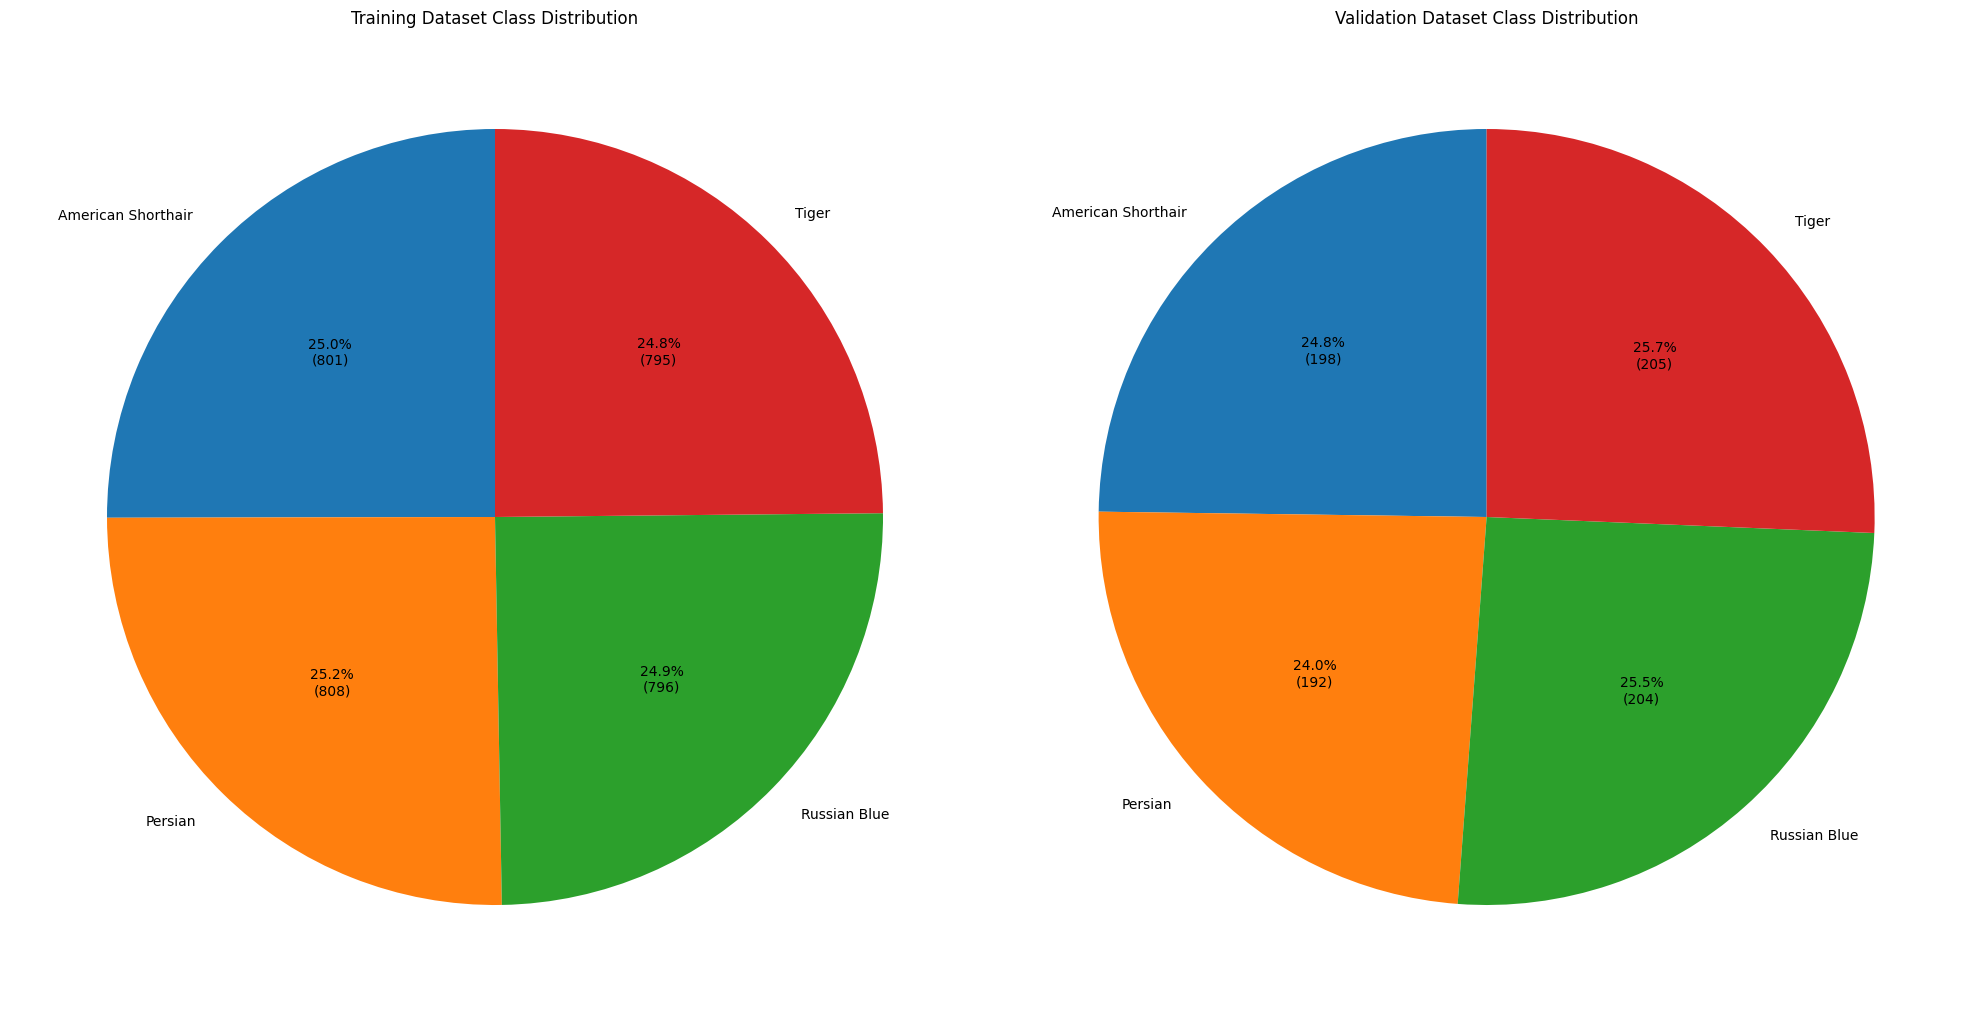

In [9]:
# Count occurrences in training dataset
train_unique_classes, train_counts = np.unique(all_train_labels, return_counts=True)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%\n({val:d})'
    return my_autopct

plt.pie(train_counts, 
        labels=[class_names[i] for i in train_unique_classes], 
        autopct=make_autopct(train_counts),
        startangle=90)
plt.title('Training Dataset Class Distribution')

# Count occurrences in validation dataset
val_unique_classes, val_counts = np.unique(all_val_labels, return_counts=True)

# Subplot for validation dataset
plt.subplot(1, 2, 2)
plt.pie(val_counts, 
        labels=[class_names[i] for i in val_unique_classes], 
        autopct=make_autopct(val_counts),
        startangle=90)
plt.title('Validation Dataset Class Distribution')

plt.tight_layout()
plt.show()

In [10]:
def create_model(pre_trained_model):
    pre_trained_model.trainable = False

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.15),      # 15% rotation
        tf.keras.layers.RandomTranslation(0.15, 0.15),  # 15% width and height shift
        tf.keras.layers.RandomShear(0.15),         # 15% shear
        tf.keras.layers.RandomZoom(
            height_factor=(-0.1, 0.1),
            width_factor=(-0.1, 0.1)
        ),
        tf.keras.layers.RandomFlip("horizontal"),  # Horizontal flip
    ], name="augmentation_layers")

    model = tf.keras.Sequential([
        layers.Rescaling(1.0 / 255, input_shape=(img_width, img_height, 3)),
        data_augmentation,
        pre_trained_model,

        # layers.Flatten(),
        layers.GlobalAveragePooling2D(),

        layers.Dense(len(train_unique_classes), activation="softmax") #Classification layer
    ])
    return model

In [ ]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

model1 = create_model(vgg16)
model1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_layers             │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)

Epoch 1/5


I0000 00:00:1743548311.934830    7586 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-02 06:58:32.653236: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-02 06:58:32.835959: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-02 06:58:33.096424: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3719 - loss: 1.3418

2025-04-02 06:59:07.194677: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-02 06:59:07.653646: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-02 06:59:08.091414: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step - accuracy: 0.3722 - loss: 1.3416 - val_accuracy: 0.5044 - val_loss: 1.2085
Epoch 2/5


2025-04-02 06:59:08.525333: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.5059 - loss: 1.2096 - val_accuracy: 0.5482 - val_loss: 1.1266
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.5361 - loss: 1.1385 - val_accuracy: 0.5657 - val_loss: 1.0836
Epoch 4/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.5467 - loss: 1.0989 - val_accuracy: 0.5745 - val_loss: 1.0590
Epoch 5/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.5702 - loss: 1.0730 - val_accuracy: 0.5832 - val_loss: 1.0207


In [13]:
model1.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.6110 - loss: 1.0214


[1.0206518173217773, 0.5832290649414062]

In [14]:
mobilenet = MobileNet(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
model2 = create_model(mobilenet)
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_layers             │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,964 (12.33 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [15]:
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)

Epoch 1/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.5012 - loss: 1.1229 - val_accuracy: 0.7572 - val_loss: 0.6632
Epoch 2/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7436 - loss: 0.6796 - val_accuracy: 0.7760 - val_loss: 0.6047
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7783 - loss: 0.5772 - val_accuracy: 0.7872 - val_loss: 0.5455
Epoch 4/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7801 - loss: 0.5510 - val_accuracy: 0.8060 - val_loss: 0.5311
Epoch 5/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.7717 - loss: 0.5379 - val_accuracy: 0.7860 - val_loss: 0.5238


In [16]:
model2.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7718 - loss: 0.5250


[0.5237914323806763, 0.7859824895858765]

In [17]:
inceptionV3 = InceptionV3(weights= "imagenet", include_top=False, input_shape=(img_height, img_width, 3))
model3 = create_model(inceptionV3)
model3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_layers             │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [18]:
history3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)

Epoch 1/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.5856 - loss: 0.9563 - val_accuracy: 0.7584 - val_loss: 0.6694
Epoch 2/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.7352 - loss: 0.6784 - val_accuracy: 0.7935 - val_loss: 0.5731
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.7322 - loss: 0.6767 - val_accuracy: 0.8073 - val_loss: 0.5759
Epoch 4/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.7679 - loss: 0.6172 - val_accuracy: 0.7847 - val_loss: 0.5541
Epoch 5/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.7637 - loss: 0.6060 - val_accuracy: 0.7947 - val_loss: 0.5825


In [19]:
model3.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7749 - loss: 0.6225


[0.5825024843215942, 0.7947434186935425]

In [20]:
resnet50 = ResNet50(weights= "imagenet", include_top=False, input_shape=(img_height, img_width, 3))
model4 = create_model(resnet50)
model4.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_layers             │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
history4 = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)

Epoch 1/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 31s 142ms/step - accuracy: 0.2494 - loss: 1.4388 - val_accuracy: 0.2891 - val_loss: 1.3601
Epoch 2/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.3098 - loss: 1.3723 - val_accuracy: 0.3354 - val_loss: 1.3417
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.3153 - loss: 1.3558 - val_accuracy: 0.3529 - val_loss: 1.3279
Epoch 4/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.3461 - loss: 1.3467 - val_accuracy: 0.3354 - val_loss: 1.3567
Epoch 5/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.3378 - loss: 1.3468 - val_accuracy: 0.3605 - val_loss: 1.3212


In [22]:
model4.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.3489 - loss: 1.3325


[1.3212450742721558, 0.3604505658149719]

In [23]:
xception = Xception(weights= "imagenet", include_top=False, input_shape=(img_height, img_width, 3))
model5 = create_model(xception)
model5.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_layers             │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [24]:
history5 = model5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
)

Epoch 1/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - accuracy: 0.6117 - loss: 0.9158 - val_accuracy: 0.7872 - val_loss: 0.5573
Epoch 2/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.7281 - loss: 0.6426 - val_accuracy: 0.7885 - val_loss: 0.5517
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.7443 - loss: 0.5955 - val_accuracy: 0.7972 - val_loss: 0.5312
Epoch 4/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.7674 - loss: 0.5737 - val_accuracy: 0.7947 - val_loss: 0.5272
Epoch 5/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.7708 - loss: 0.5517 - val_accuracy: 0.8048 - val_loss: 0.5296


In [25]:
model5.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.8277 - loss: 0.5072


[0.5295731425285339, 0.8047559261322021]

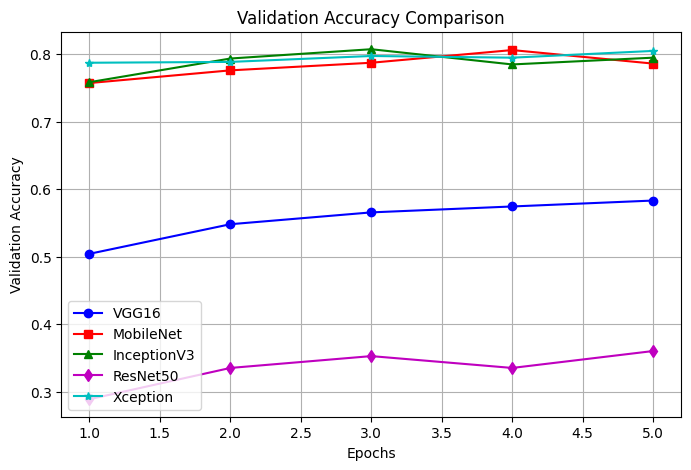

In [26]:
val_acc1 = history1.history['val_accuracy']
val_acc2 = history2.history['val_accuracy']
val_acc3 = history3.history['val_accuracy']
val_acc4 = history4.history['val_accuracy']
val_acc5 = history5.history['val_accuracy']

epochs_range = range(1, len(val_acc1) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, val_acc1, 'b-o', label="VGG16")
plt.plot(epochs_range, val_acc2, 'r-s', label="MobileNet")
plt.plot(epochs_range, val_acc3, 'g-^', label="InceptionV3")
plt.plot(epochs_range, val_acc4, 'm-d', label="ResNet50")
plt.plot(epochs_range, val_acc5, 'c-*', label="Xception")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


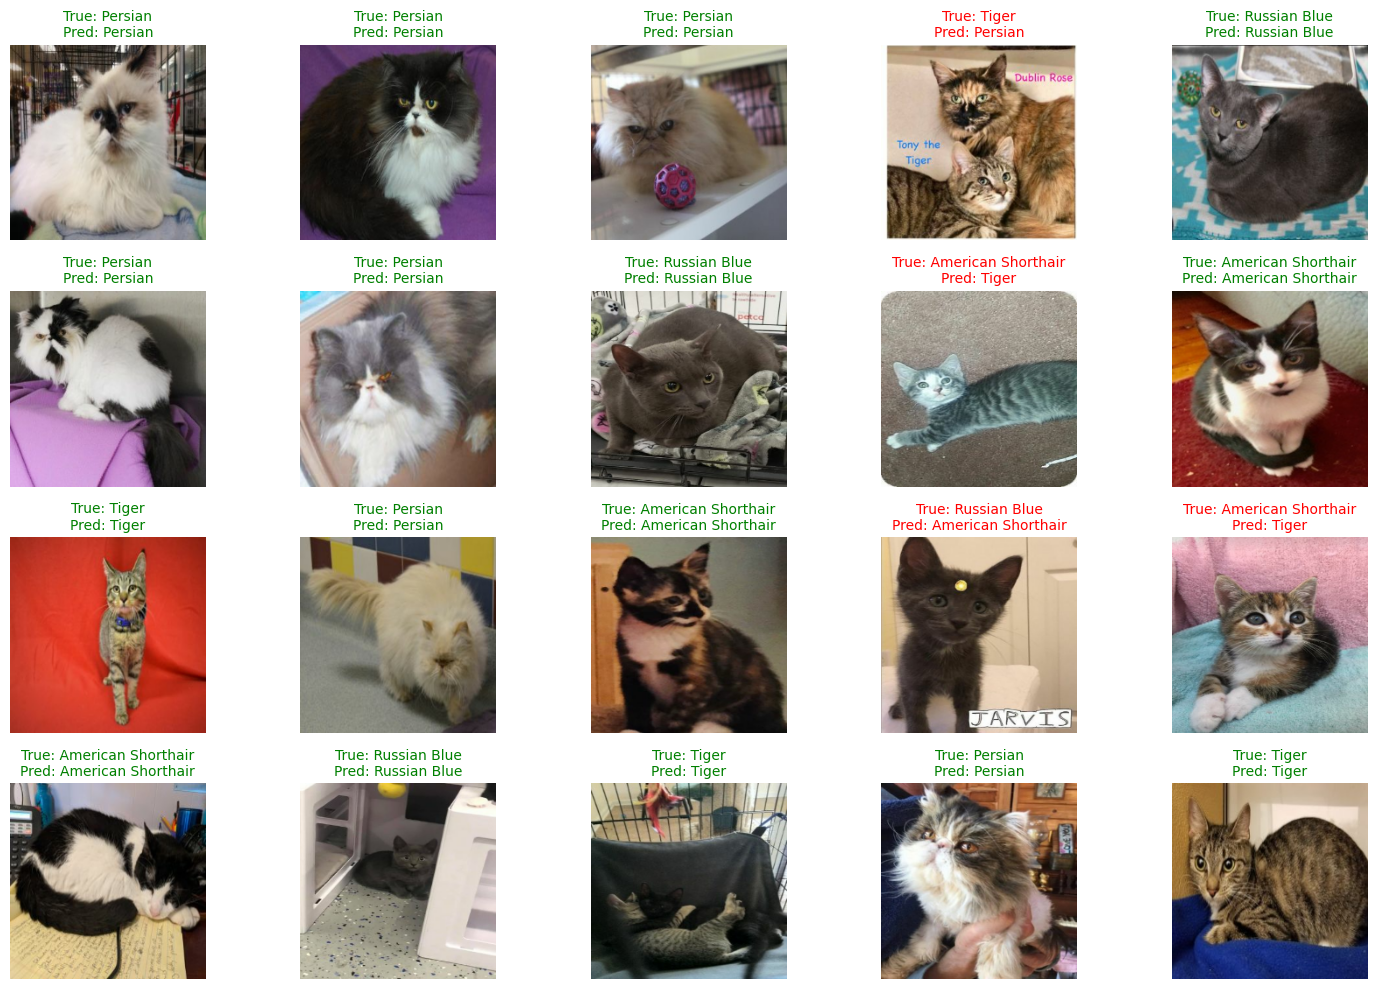

In [126]:
# predictions = model1.predict(val_ds)
# predicted_labels = np.argmax(predictions, axis=1)

for images, labels in val_ds.take(1):
    first_batch_predictions = model5.predict(images)
    first_batch_predicted_labels = np.argmax(first_batch_predictions, axis=1)
    first_batch_true_labels = labels.numpy()
    # print("\nPredictions on the first batch:", first_batch_predicted_labels)
    # print("True labels of the first batch:", first_batch_true_labels)
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        true_label = class_names[labels[i].numpy()]
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_label = class_names[first_batch_predicted_labels[i]]
        title_color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=title_color, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()